In [160]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

import seaborn as sns

import pickle

In [111]:
import pandas as pd

# dataset PATH
df = pd.read_csv(r"C:\Users\gabe7\CSU Fullerton Dropbox\Gabriel Rodriguez\Breast_Cancer_Dataset\final_features.csv")

# Extract features and label
X = df.drop(["Patient ID", "Staging(Tumor Size)# [T]"], axis=1)
y = df["Staging(Tumor Size)# [T]"]


In [112]:
print(df.columns.tolist())


['Patient ID', 'Staging(Tumor Size)# [T]', 'Staging(Nodes)#(Nx replaced by -1)[N]', 'Staging(Metastasis)#(Mx -replaced by -1)[M]', 'Age at mammo (days)', 'Tumor Size (cm).1', 'TumorMajorAxisLength_mm', 'Tumor Location', 'Menopause (at diagnosis)', 'Volume_cu_mm_Tumor', 'Lymphadenopathy or Suspicious Nodes', 'Metastatic at Presentation (Outside of Lymph Nodes)', 'Peak_SER_tumor', 'Grouping_based_proportion_of_tumor_voxels_3D_tumor_Group_3', 'WashinRate_PC2', 'WashinRate_PC3', 'ser_pe_PC4', 'ser_pe_PC7', 'Autocorrelation_Tumor', 'Energy_Tumor', 'Variance_of_RGH_values_Tumor', 'Mean_norm_DLBP_max_timepoint_binsize_256_with_filling_Tumor', 'Echogenicity']


In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [114]:
selector = SelectKBest(score_func=f_classif, k=15)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

top_features = X.columns[selector.get_support()]
print("Top 15 features:\n", top_features)


Top 15 features:
 Index(['Staging(Nodes)#(Nx replaced by -1)[N]', 'TumorMajorAxisLength_mm',
       'Menopause (at diagnosis)', 'Volume_cu_mm_Tumor',
       'Lymphadenopathy or Suspicious Nodes',
       'Metastatic at Presentation (Outside of Lymph Nodes)', 'Peak_SER_tumor',
       'Grouping_based_proportion_of_tumor_voxels_3D_tumor_Group_3',
       'WashinRate_PC2', 'ser_pe_PC7', 'Autocorrelation_Tumor', 'Energy_Tumor',
       'Variance_of_RGH_values_Tumor',
       'Mean_norm_DLBP_max_timepoint_binsize_256_with_filling_Tumor',
       'Echogenicity'],
      dtype='object')


In [115]:
#Random Forest on FULL FEATURES
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
rf_score = model_rf.score(X_test, y_test)
print("Random Forest Accuracy:", rf_score)

# Save model
# pickle.dump(model_rf, open("finalized_model_RF.model", 'wb'))


Random Forest Accuracy: 0.6432432432432432


In [116]:
#Logistical Regression on REDUCED FEATURES
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_reduced, y_train)
lr_score = model_lr.score(X_test_reduced, y_test)
print("Logistic Regression Accuracy (Top 15 features):", lr_score)

# Save model
# pickle.dump(model_lr, open("finalized_model_LR.model", 'wb'))


Logistic Regression Accuracy (Top 15 features): 0.5945945945945946


In [188]:
# Support Vector Classifier
model_svc = SVC(
    probability=True,
    kernel='rbf',
    C=2.5,
    gamma='scale',
)
model_svc.fit(X_train, y_train)
svc_score = model_svc.score(X_test, y_test)
print("SVC Accuracy:", svc_score)

# Save model
# pickle.dump(model_svc, open("finalized_model_SVC.model", 'wb'))

SVC Accuracy: 0.5783783783783784


In [189]:
# K-Nearest Neighbors (KNN)
model_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance',
    metric='minkowski'
)
model_knn.fit(X_train, y_train)
knn_score = model_knn.score(X_test, y_test)
print("KNN Accuracy:", knn_score)

# Save model
# pickle.dump(model_knn, open("finalized_model_KNN.model", 'wb'))

KNN Accuracy: 0.5621621621621622


# **Performance Evaluation**

**Plot ROC Curve Function**

In [212]:

def plot_roc(model, y_test, y_pred, class_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']):
    # Get unique classes
    classes = np.unique(y_test)
    n_classes = len(classes)
    
    # Binarize the labels for multiclass ROC
    y_test_bin = label_binarize(y_test, classes=classes)
    
    # If binary classification, reshape
    if n_classes == 2:
        y_test_bin = np.hstack([1 - y_pred[:, 1:2], y_pred[:, 1:2]])
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    
    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    # Plot ROC curve for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        class_label = class_names[i] if class_names else f'Class {i}'
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_label} (AUC = {roc_auc[i]:.2f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Multiclass ROC Curves', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

**Random Forest Confusion Matrix Heatmap**

In [213]:
y_pred = model_rf.predict(X_test)

**Get Random Forest Metrics**

In [214]:
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average='weighted')
rf_recall = recall_score(y_test, y_pred, average='weighted')

C:\Users\gabe7\PycharmProjects\Breast-Cancer-Stage-Prediction\.venv\Scripts\python.exe\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


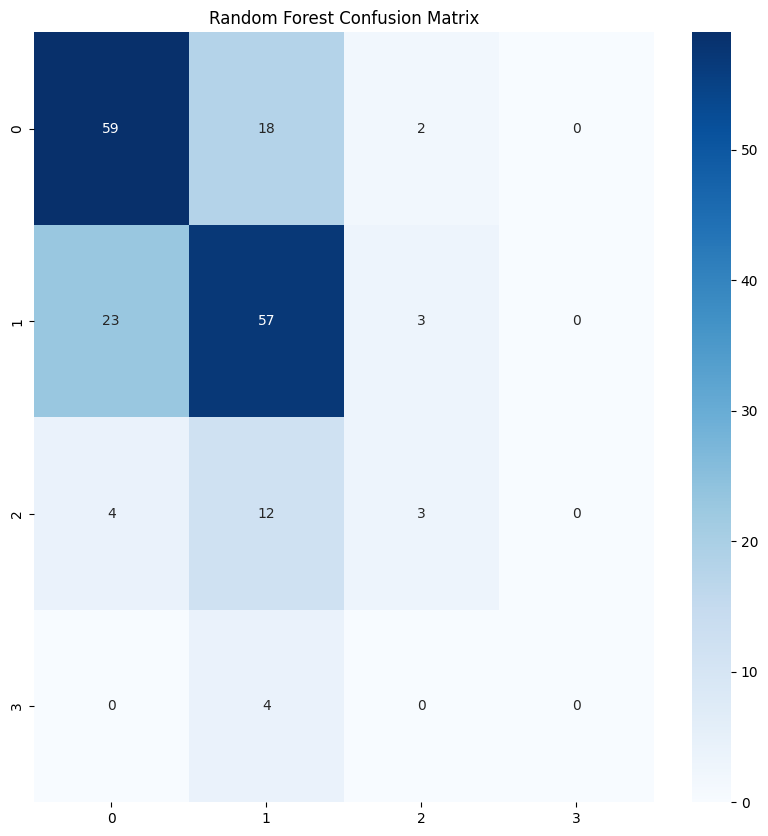

In [215]:
rf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Tumor Label')
plt.ylabel('True Tumor Label')
sns.heatmap(rf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.show()

# **Plot Random Forest ROC Curve**

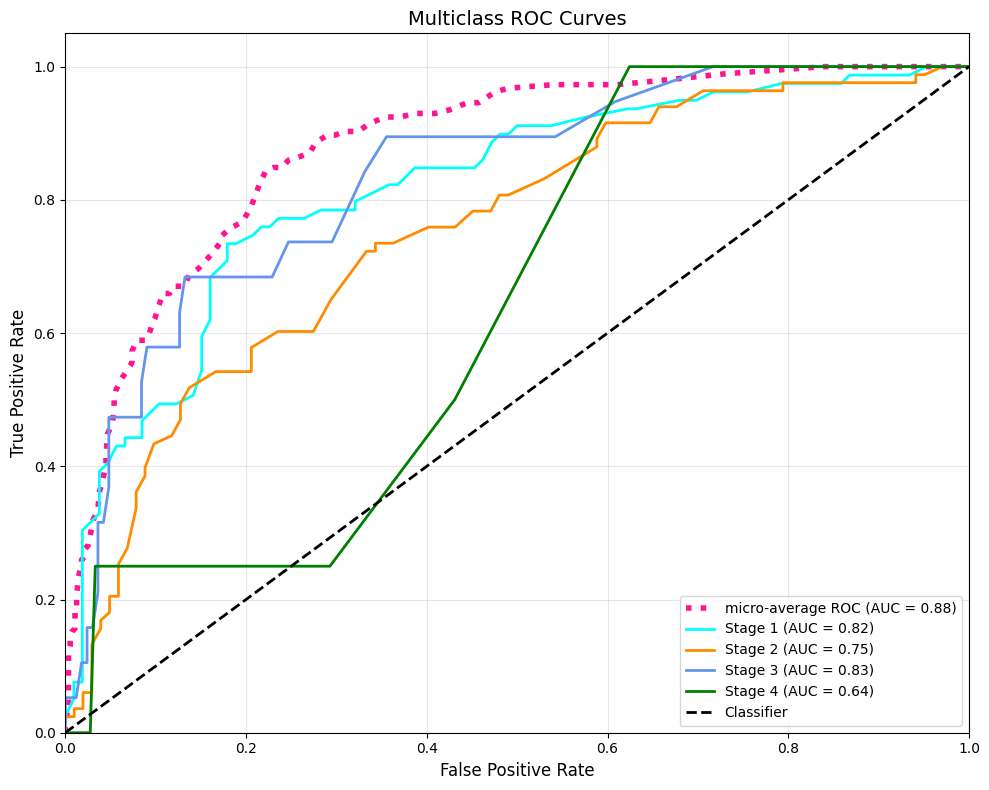

In [216]:
y_pred_proba = model_rf.predict_proba(X_test)
plot_roc(model_rf, y_test, y_pred_proba)

**Random Forest Confusion Matrix Heatmap**

In [195]:
y_pred = model_lr.predict(X_test_reduced)

**Get Logistic Rogression Metrics**

In [196]:
lr_accuracy = accuracy_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred, average='weighted')
lr_recall = recall_score(y_test, y_pred, average='weighted')

C:\Users\gabe7\PycharmProjects\Breast-Cancer-Stage-Prediction\.venv\Scripts\python.exe\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


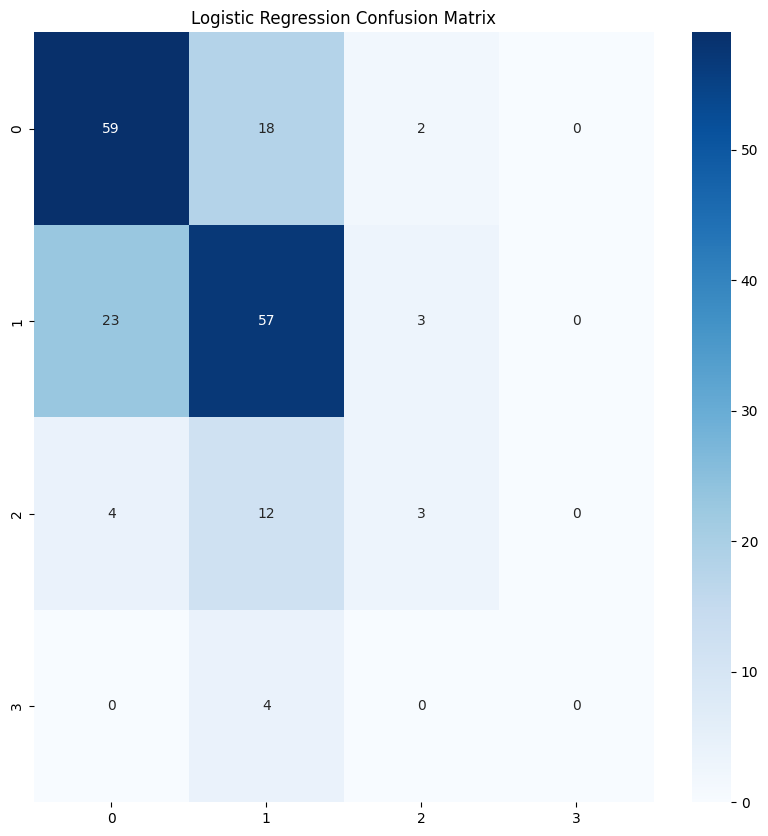

In [197]:
lr_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Tumor Label')
plt.ylabel('True Tumor Label')
sns.heatmap(rf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.show()

# **Plot Logistic Regression ROC Curve**

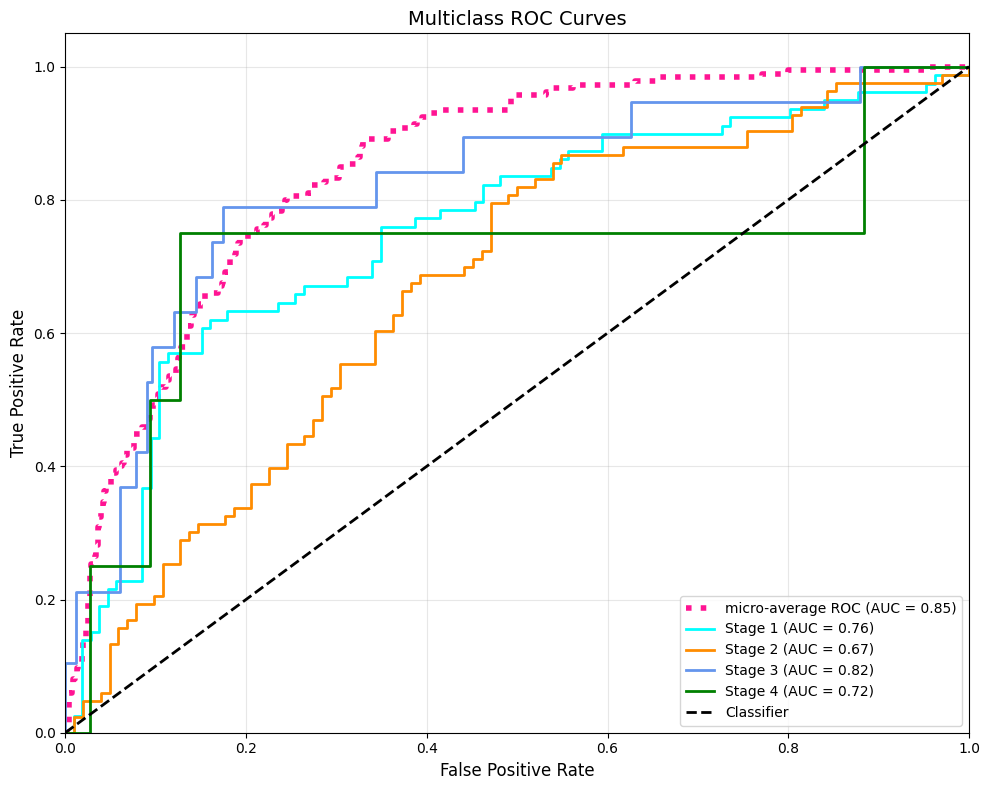

In [217]:
y_pred_proba = model_lr.predict_proba(X_test_reduced)
plot_roc(model_lr, y_test, y_pred_proba)

**Support Vector Machine Confusion Matrix Heatmap**

In [199]:
y_pred = model_svc.predict(X_test)

**Get Support Vector Machine Metrics**

In [200]:
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred, average='weighted')
svm_recall = recall_score(y_test, y_pred, average='weighted')

C:\Users\gabe7\PycharmProjects\Breast-Cancer-Stage-Prediction\.venv\Scripts\python.exe\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


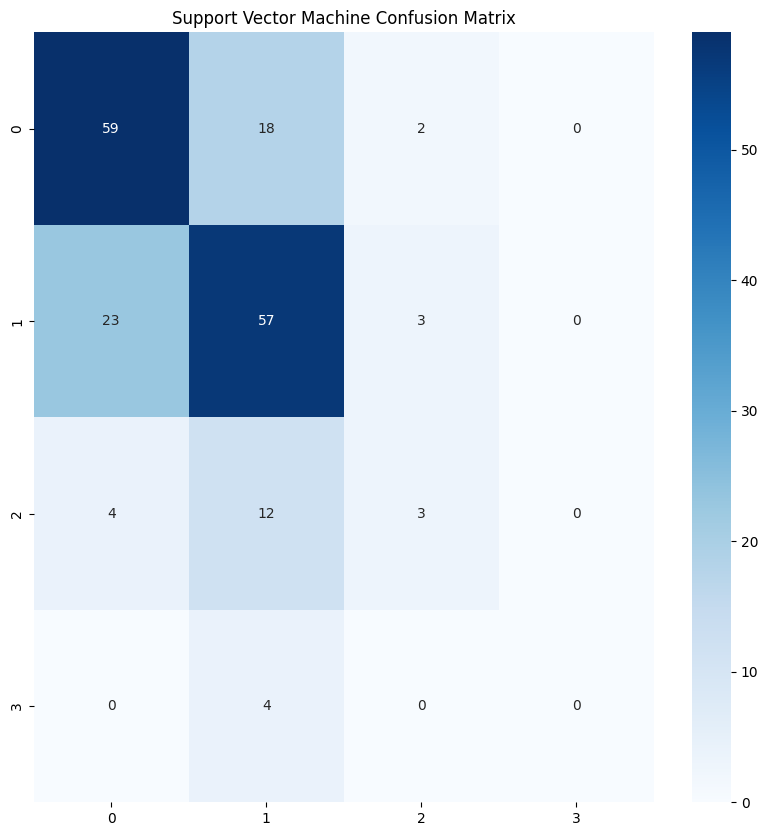

In [201]:
svm_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.title('Support Vector Machine Confusion Matrix')
plt.xlabel('Predicted Tumor Label')
plt.ylabel('True Tumor Label')
sns.heatmap(rf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.show()

# **Plot Support Vector Machine ROC Curve**

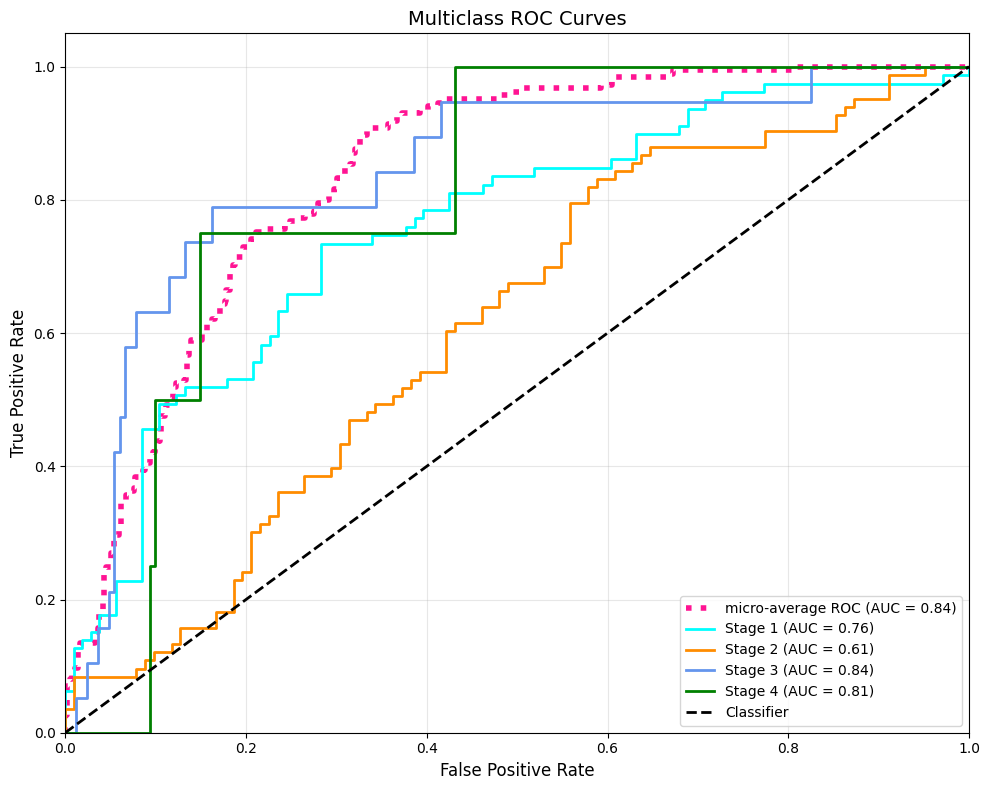

In [218]:
y_pred_proba = model_svc.predict_proba(X_test)
plot_roc(model_svc, y_test, y_pred_proba)

**K-Nearest Neighbors Confusion Matrix Heatmap**

In [203]:
y_pred = model_knn.predict(X_test)

**Get K-Nearest Neighbors Metrics**

In [204]:
knn_accuracy = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred, average='weighted')
knn_recall = recall_score(y_test, y_pred, average='weighted')

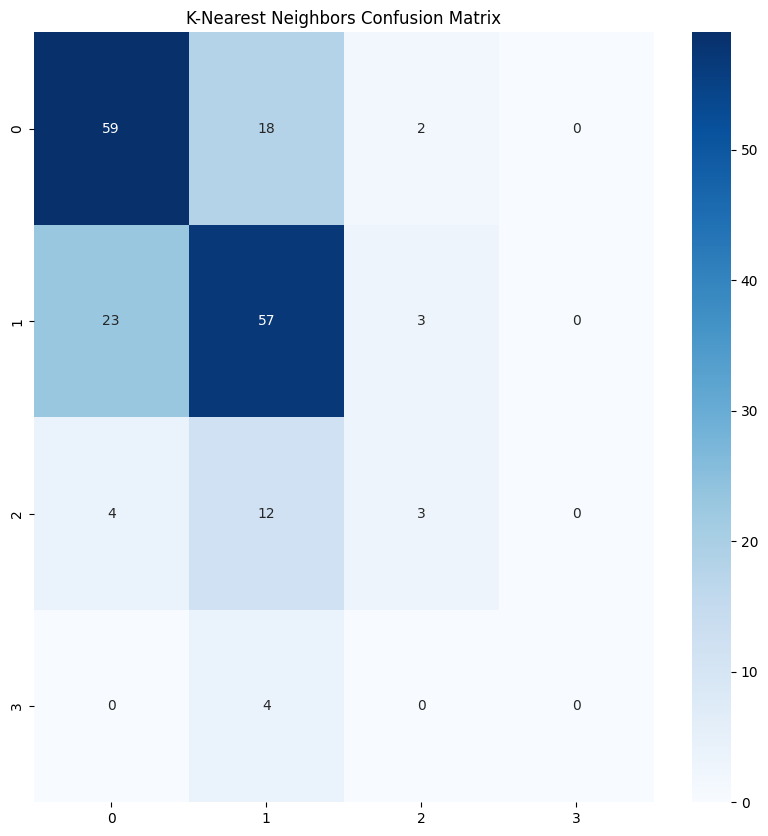

In [205]:
knn_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.xlabel('Predicted Tumor Label')
plt.ylabel('True Tumor Label')
sns.heatmap(rf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.show()

# **Plot K-Nearest Neighbors ROC Curve**

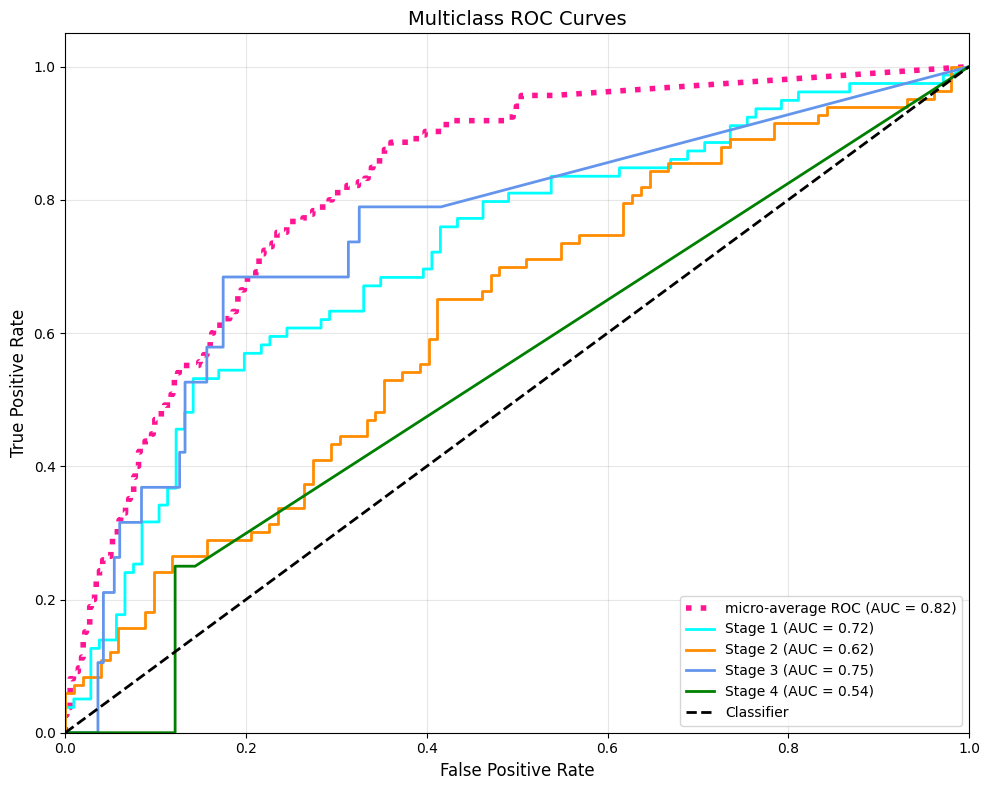

In [219]:
y_pred_proba = model_knn.predict_proba(X_test)
plot_roc(model_knn, y_test, y_pred_proba)

# **Model Performance Metric Visualizations**

In [207]:
models = ['Random Forest', 'Logistic Regression', 'SVM', 'KNN']

**Accuracy Score**

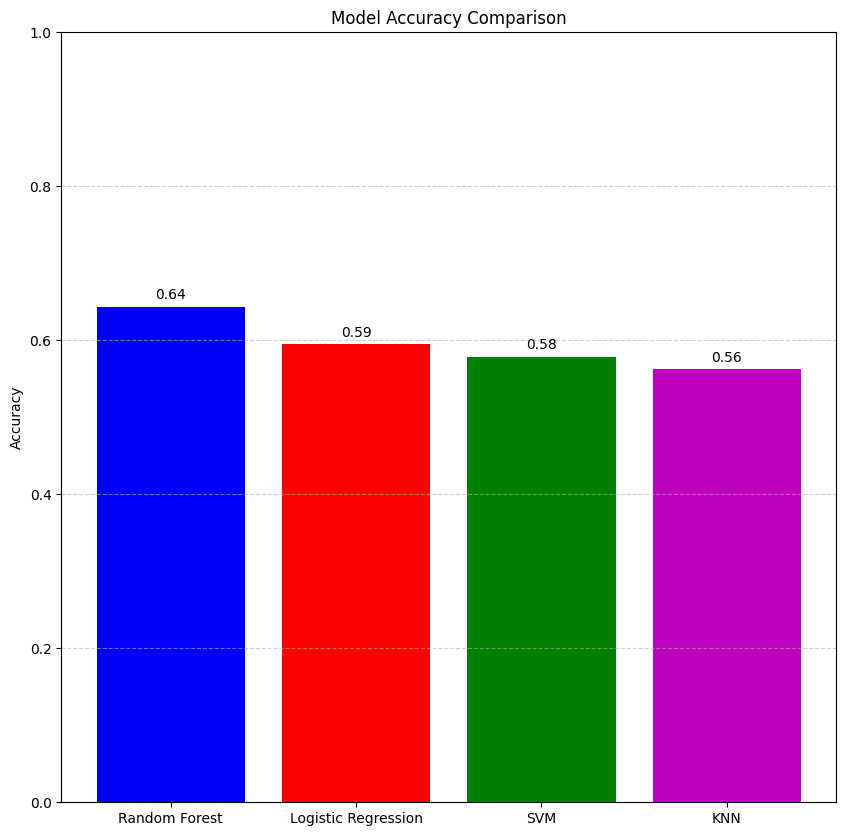

In [208]:
accuracies = [rf_accuracy, lr_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(10,10))
plt.bar(models, accuracies, color=['b', 'r', 'g', 'm'])
plt.ylim(0, 1)  # accuracy ranges from 0 to 1
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.show()

**Precision Score**

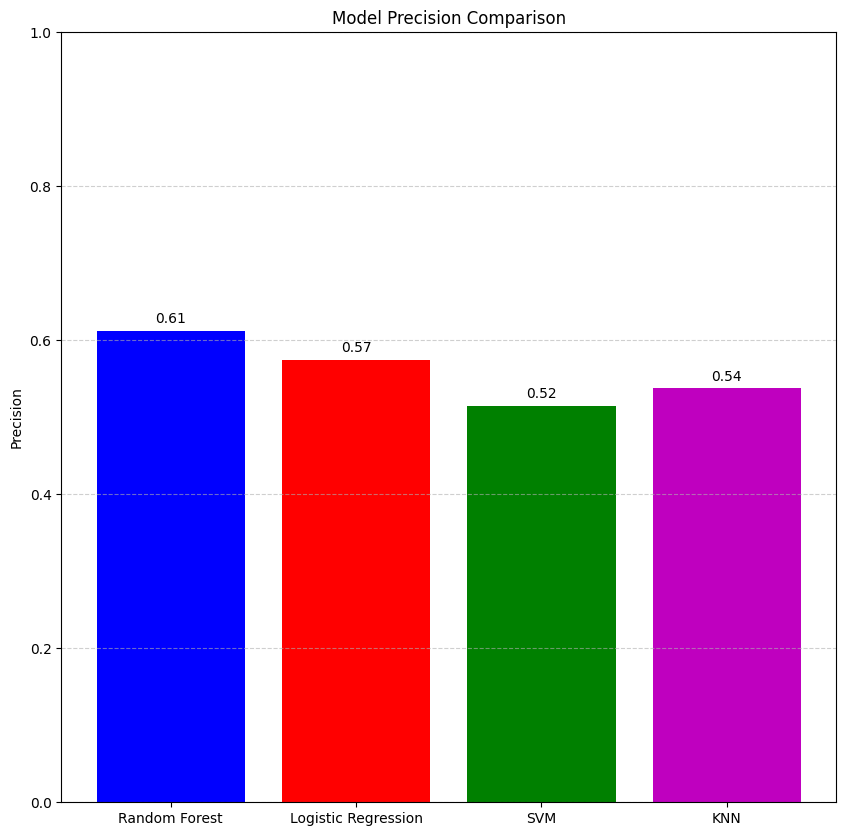

In [209]:
precisions = [rf_precision, lr_precision, svm_precision, knn_precision]

plt.figure(figsize=(10,10))
plt.bar(models, precisions, color=['b', 'r', 'g', 'm'])
plt.ylim(0, 1)  # Precision ranges from 0 to 1
plt.ylabel("Precision")
plt.title("Model Precision Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of the bars
for i, v in enumerate(precisions):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.show()

**Recall Score**

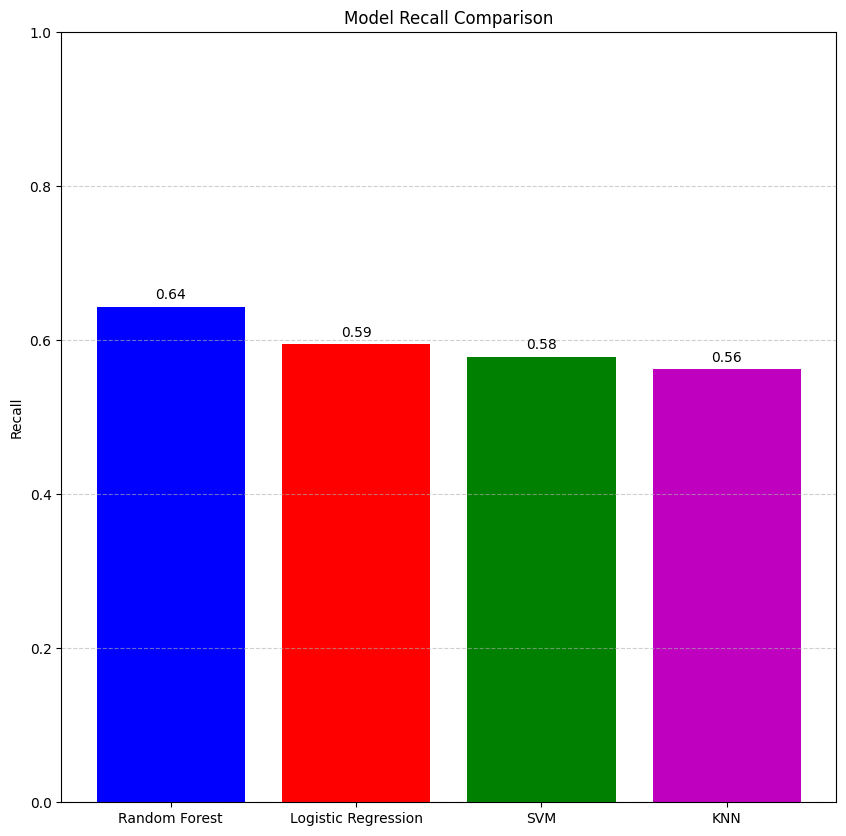

In [210]:
recalls = [rf_recall, lr_recall, svm_recall, knn_recall]

plt.figure(figsize=(10,10))
plt.bar(models, recalls, color=['b', 'r', 'g', 'm'])
plt.ylim(0, 1)  # Recall ranges from 0 to 1
plt.ylabel("Recall")
plt.title("Model Recall Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of the bars
for i, v in enumerate(recalls):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.show()